In [41]:
import h5py
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# LOAD DATA

In [ ]:
f = h5py.File('/content/bird_spectrograms.hdf5', 'r')

# EXPLORE DATA

In [ ]:
print("Bird Species:", list(f.keys()))

Bird Species: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']


In [ ]:
for key in f.keys():
    print(f"{key}: shape = {f[key].shape}")

amecro: shape = (128, 517, 66)
amerob: shape = (128, 517, 172)
bewwre: shape = (128, 517, 144)
bkcchi: shape = (128, 517, 45)
daejun: shape = (128, 517, 125)
houfin: shape = (128, 517, 84)
houspa: shape = (128, 517, 630)
norfli: shape = (128, 517, 37)
rewbla: shape = (128, 517, 187)
sonspa: shape = (128, 517, 263)
spotow: shape = (128, 517, 137)
whcspa: shape = (128, 517, 91)


128 represents the number of Mel frequency Bands, 517 represents the time frames and the third value represents the number of clips recorded for each bird species.

.

.

Next, I want to visually inspect the spectrograms of each bird specie to fine the pair with the strongest frequencies that would be ideal for this binary classification.

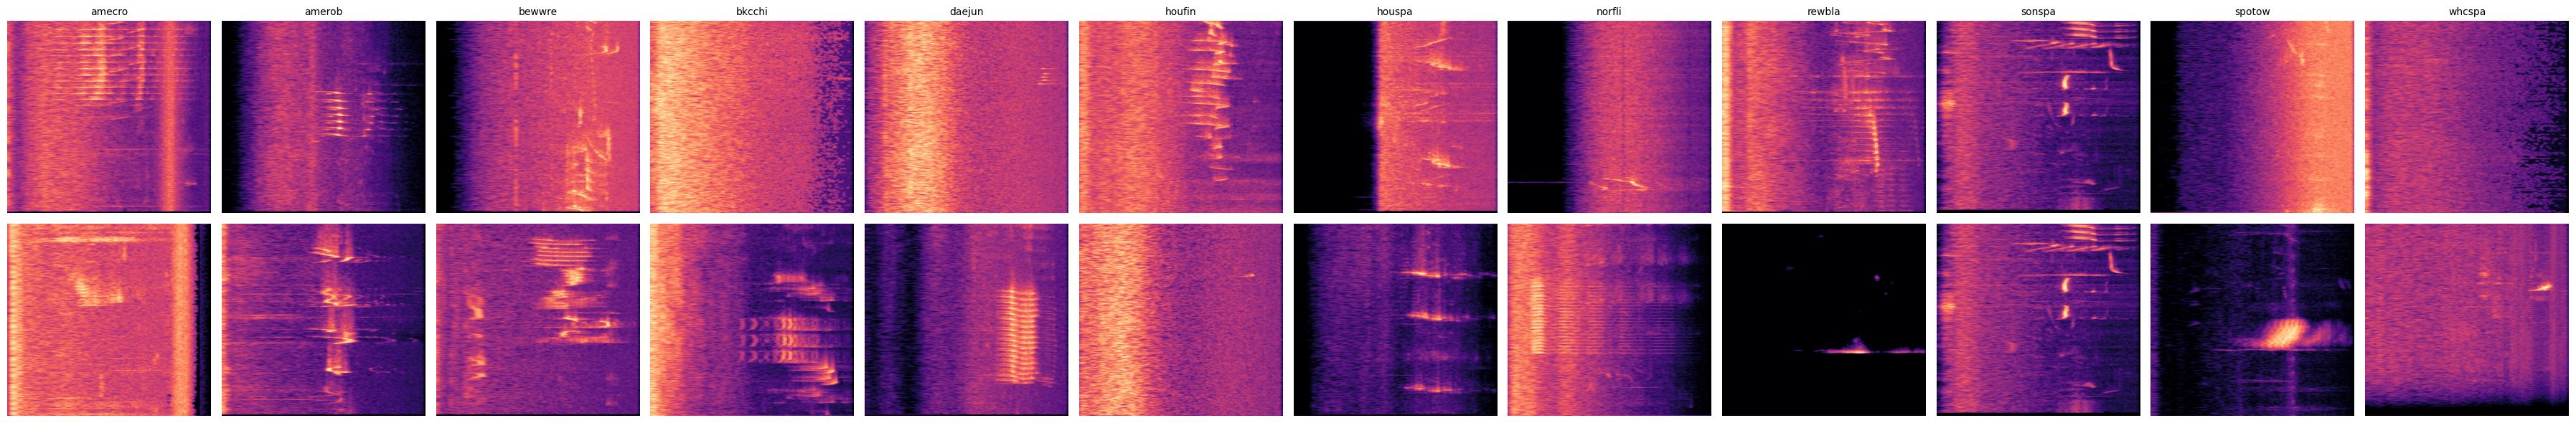

In [ ]:
bird_keys = list(f.keys())

samples_per_bird = 2
num_birds = len(bird_keys)

plt.figure(figsize=(num_birds * 3, samples_per_bird * 3))

plot_idx = 1

for j in range(samples_per_bird):
    for bird in bird_keys:
        spectrograms = f[bird][:]
        n_samples = spectrograms.shape[-1]

        # Randomly choose a spectrogram index (I did this so that each time i run it i get new samples)
        selected_idx = random.randint(0, n_samples - 1)
        spec = spectrograms[:, :, selected_idx].T

        plt.subplot(samples_per_bird, num_birds, plot_idx)
        plt.imshow(spec, aspect='auto', origin='lower', cmap='magma')
        if j == 0:
            plt.title(bird, fontsize=10)
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.show()

After running these a couple of times, the birds with the strongest frequency from my visual inspection are Daejun and Spotow. In addiction to the frequencies, these two birds I have chosen have a good sample size to train the model on. Now I can process to preprocess the data.

# PREPROCESSING FOR BINARY CLASSIFICATION



Aproach: I will normalize the spectograms, add a channel dimention For preprocessing as CNNs expect 3D inputs and the h5 files are 2D. I will label each sample and lastly split the data 3 ways (training set, laidation set and test set).

- Although the input feature's dimentions (128 x 517) are the same for all samples, normalization is important because we want to standardize the magnitude of the spectrogram values. This difference might arise due to varying pixel values.

In [ ]:
selected_species = ['daejun', 'spotow']

def pad_spectrogram(spec, target_width=128):
    current_width = spec.shape[1]
    if current_width >= target_width:
        return spec[:, :target_width]
    else:
        pad_width = target_width - current_width
        return np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')

target_width = 128
x_binary =[]
y_binary = []

for label in selected_species:
    data = np.array(f[label])
    for spec in data:
        padded = pad_spectrogram(spec, target_width)
        x_binary.append(padded)
        y_binary.append(label)
x_binary = np.array(x_binary)
y_binary = np.array(y_binary)
x_binary = x_binary[..., np.newaxis]

#normalization: this scales each spectrogram  between range 0-1, specifically to accoint for noice variation between clips.
x_binary = np.clip(x_binary, a_min=0.0, a_max=None)
x_binary = x_binary / np.max(x_binary)
x_binary = np.nan_to_num(x_binary, nan=0.0, posinf=0.0, neginf=0.0)


#Add labels: 0  represents "daejun" and 1 represents "spotow"
binary_label = LabelEncoder()
labeled_y_binary = binary_label.fit_transform(y_binary)


# Initially perform an 80/20 train test split split
X_train_temp, X_test_bin, y_train_temp, y_test_bin = train_test_split(x_binary, labeled_y_binary, test_size=0.2, stratify=labeled_y_binary, random_state=42)

# Further split training data into the main training data and a validation set
X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, random_state=42)

print("Train:", X_train_bin.shape)
print("Val:", X_val_bin.shape)
print("Test:", X_test_bin.shape)



Train: (153, 517, 128, 1)
Val: (51, 517, 128, 1)
Test: (52, 517, 128, 1)


After I normalized per clip, I noticed that I had varying spectogram lengths and the model did not like that so I padded with zeros to inputs the same shape for batching.

In [ ]:
print("x_binary shape:", x_binary.shape)
print("x_binary min:", np.min(x_binary))
print("x_binary max:", np.max(x_binary))
print("x_binary mean:", np.mean(x_binary))
print("x_binary std:", np.std(x_binary))
print("Unique y labels:", np.unique(labeled_y_binary))


x_binary shape: (256, 517, 128, 1)
x_binary min: 0.0
x_binary max: 1.0
x_binary mean: 6.769796404663322e-07
x_binary std: 0.0006379599603411184
Unique y labels: [0 1]


I printed these values to  verify that after my preprocessing, the input data was correctly normalized and shaped, and to check the label distribution for class imbalance or errors. Now I can proceed to build my model.

### BUILDING THE BINARY MODEL - Iteration 1

In [ ]:
X_train_bin.shape[1:]

(517, 128, 1)

In [ ]:
model1 = models.Sequential([
    Input(shape=(517, 128, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 515, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 255, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 23,041 (90.00 KB)

 Non-trainable params: 0 (0.00 B)

I initially used Flatten() and found from the model summary with Flatten() that the model would most likely overfit since there were over 15 million parameters.
 * [dense_2 (Dense)                 │ (None, 64)             │    15,605,824 ]

There for, I changed to GlobalAveragePooling2D() to address this overfitting. Now the trainable parameters has been reduced to 23,041. This looks better. I can then proceed to train the model

# Train the model

In [ ]:
history_bin = model1.fit(
    X_train_bin, y_train_bin,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_bin, y_val_bin),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5063 - loss: 0.6933 - val_accuracy: 0.4902 - val_loss: 0.6933
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5033 - loss: 0.6931 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.4820 - loss: 0.6933 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.4924 - loss: 0.6932 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5167 - loss: 0.6931 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5280 - loss: 0.6930 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5228 - loss: 0.6930 - val_accuracy: 0.4902 - val_loss: 0.6933


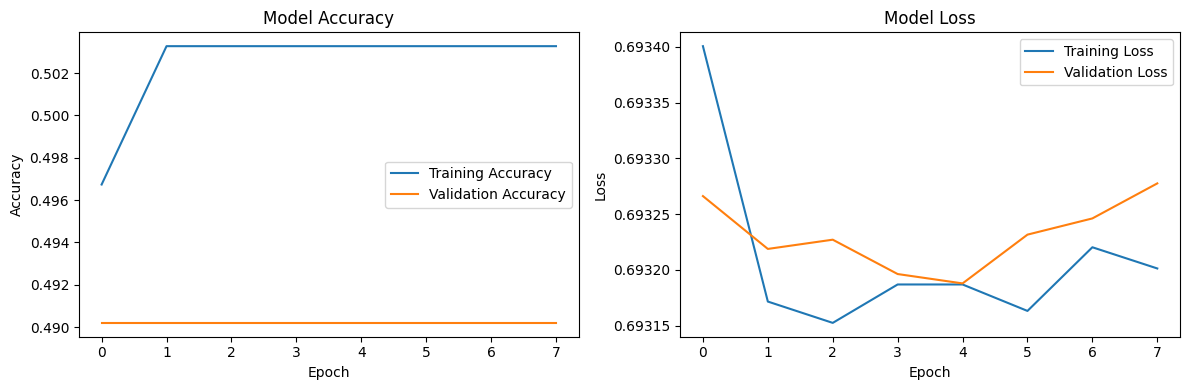

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bin.history['accuracy'], label='Training Accuracy')
plt.plot(history_bin.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_bin.history['loss'], label='Training Loss')
plt.plot(history_bin.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In the first few epochs, the model didn’t really learn anything — both training and validation accuracy stayed around 50%, and the loss didn’t change much either. Its as good as flipping a coin... I need to tune some hyperparameters and modify the neural network architecture to help the model start learning.

### BUILDING THE BINARY MODEL - Iteration 2

Actitecture change: I removed the dropout(0.3) to deepen the training.

In [17]:
model2 = models.Sequential([
    Input(shape=(517, 128, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [18]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 515, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 255, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 23,041 (90.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history_bin2 = model2.fit(
    X_train_bin, y_train_bin,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_bin, y_val_bin),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4476 - loss: 0.6933 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5228 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5176 - loss: 0.6931 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.4902 - val_loss: 0.6932


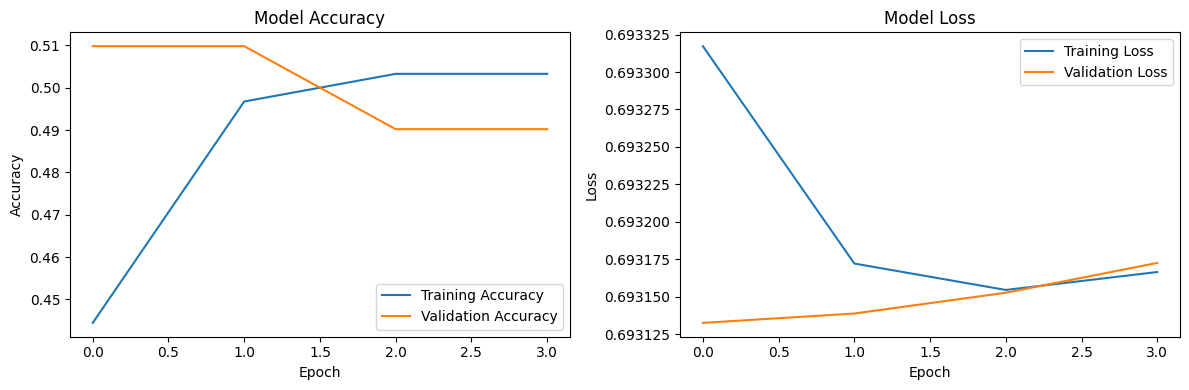

In [21]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bin2.history['accuracy'], label='Training Accuracy')
plt.plot(history_bin2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_bin2.history['loss'], label='Training Loss')
plt.plot(history_bin2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In this second attempt, the model performed a little differently, but still didn’t really learn. Training accuracy went up a bit at first but didn’t improve overall, and validation accuracy stayed around 50%. The loss values also stayed basically the same. So it’s still just guessing

### BUILDING THE BINARY MODEL - Iteration 3:

In [22]:
model3 = models.Sequential([
    Input(shape=(517, 128, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),


    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

history_bin3 = model3.fit(
    X_train_bin, y_train_bin,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_bin, y_val_bin),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 515, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 255, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 23,041 (90.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4685 - loss: 0.6932 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5427 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4993 - loss: 0.6931 - val_accuracy: 0.5098 - val_loss: 0.6931


This third model shows slight improvements, especially in training accuracy, it went up to 54%, but validation accuracy is still stuck at 50.98% and the loss stays around 0.6931. This means the model is still struggling to learn meaningful patterns. It's just guessing slightly better on the training data, but not generalizing.

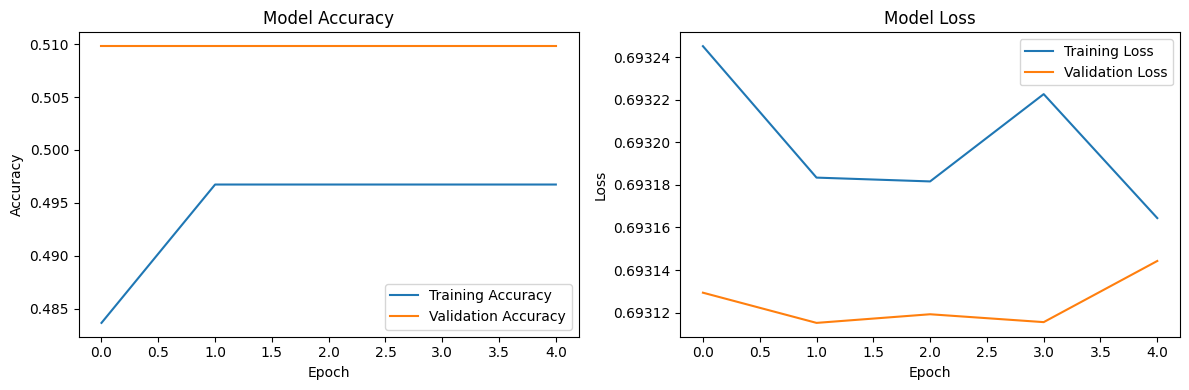

In [24]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bin3.history['accuracy'], label='Training Accuracy')
plt.plot(history_bin3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_bin3.history['loss'], label='Training Loss')
plt.plot(history_bin3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

I want to check for class imbalance

In [25]:
print(np.unique(y_train_bin, return_counts=True))

(array([0, 1]), array([76, 77]))


### BINARY MODEL: Iteration 4

 Its clear that this is  not the problem so my next approach would be to increase model complexity by adding  more layers and filters. I also added batch normalization to keeping activations stable and well-scaled throughout the networ

In [26]:
model4 = models.Sequential([
    Input(shape=(517, 128, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model4.summary()

history_bin4 = model4.fit(
    X_train_bin, y_train_bin,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_bin, y_val_bin),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 515, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 515, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 255, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 255, 61, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 28, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 125, 28, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 62, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 7s/step - accuracy: 0.4998 - loss: 0.6993 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.4446 - loss: 0.7069 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.5889 - loss: 0.6879 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5458 - loss: 0.7079 - val_accuracy: 0.4902 - val_loss: 0.6933
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.5571 - loss: 0.6859 - val_accuracy: 0.4902 - val_loss: 0.6932


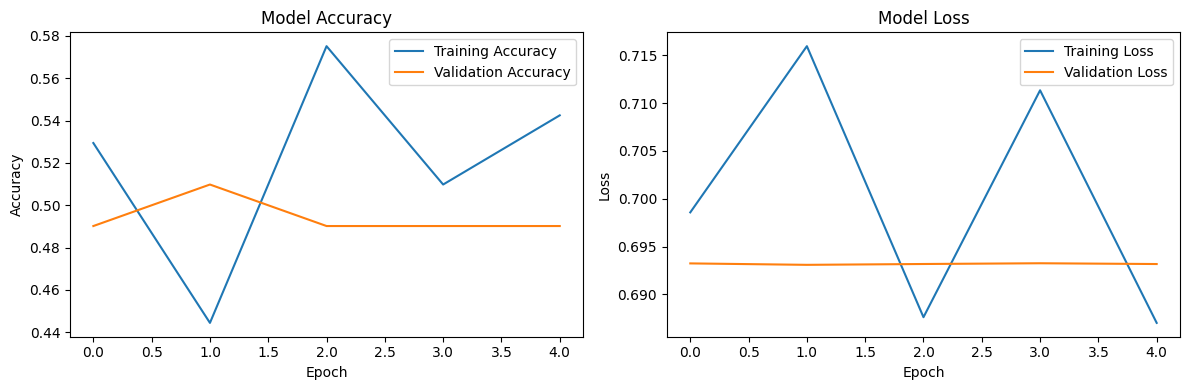

In [27]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bin4.history['accuracy'], label='Training Accuracy')
plt.plot(history_bin4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_bin4.history['loss'], label='Training Loss')
plt.plot(history_bin4.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### BUILDING THE BINARY MODEL - Iteration 5:

Here I

In [29]:
model5 = models.Sequential([
    Input(shape=(517, 128, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

model5.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model5.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


history = model5.fit(
    X_train_bin, y_train_bin,
    epochs=30,
    validation_data=(X_val_bin, y_val_bin),
    callbacks=[early_stop],
    batch_size=32,
    verbose=1
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 515, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 515, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 257, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 255, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 255, 61, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 127, 30, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 28, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 28, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 62, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,209 (430.50 KB)

 Trainable params: 109,761 (428.75 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.4828 - loss: 0.6877 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.4307 - loss: 0.7137 - val_accuracy: 0.5098 - val_loss: 0.6930
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 7s/step - accuracy: 0.4415 - loss: 0.7003 - val_accuracy: 0.5098 - val_loss: 0.6930
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5050 - loss: 0.6980 - val_accuracy: 0.5098 - val_loss: 0.6930
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.4950 - loss: 0.6868 - val_accuracy: 0.5098 - val_loss: 0.6931
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.4785 - loss: 0.6996 - val_accuracy: 0.4902 - val_loss: 0.6932
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.4694 - loss: 0.6949 - val_accuracy: 0.4902 - val_loss: 0.6933
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - accuracy: 0.5623 - loss: 0.6874 - val_accuracy: 0.4902 - val_loss: 0.6934


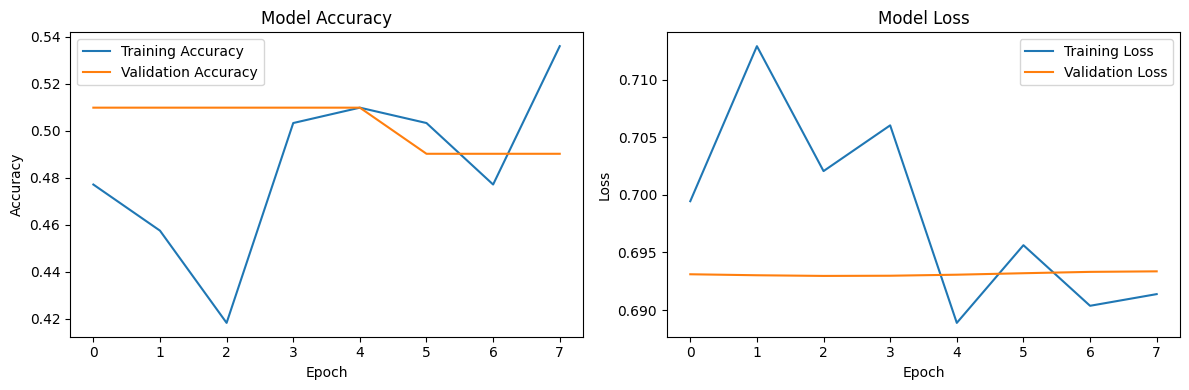

In [30]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The model still isn’t really learning — validation accuracy is stuck at 50.98% from the very beginning. Training accuracy bounces around and even hits 56% at one point, but the loss doesn’t really go down in a meaningful way. So even with more epochs and a lower learning rate, it’s still guessing on the validation set.

### BUILDING THE BINARY MODEL: ITERATION 6

The problem seems to be with how I have preprocessed the data so I am going to try another approach to normalization.

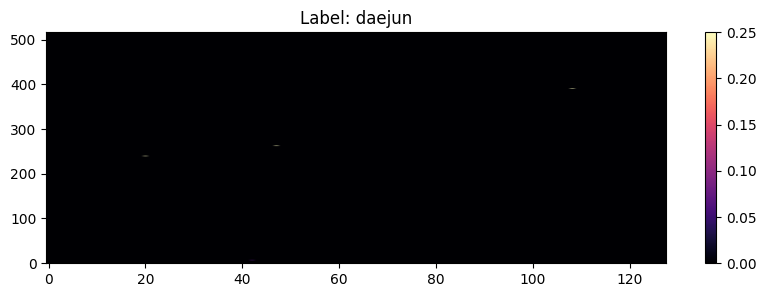

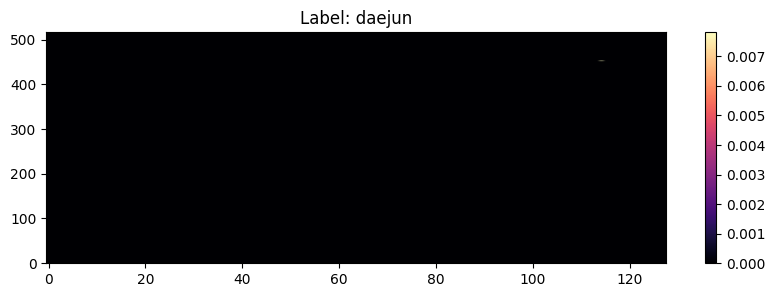

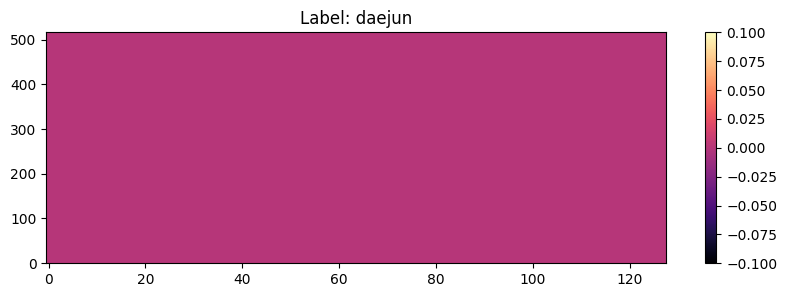

In [31]:
for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.imshow(x_binary[i].squeeze(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Label: {y_binary[i]}")
    plt.colorbar()
    plt.show()

This makes sense why the model isnt working well- some of the samples are not showing any signal. I have to adjust how I am normalizing.

In [35]:
selected_species = ['daejun', 'spotow']

def pad_spectrogram(spec, target_width=128):
    current_width = spec.shape[1]
    if current_width >= target_width:
        return spec[:, :target_width]
    else:
        pad_width = target_width - current_width
        return np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')

target_width = 128
x_binary2 = []
y_binary2 = []

threshold = 0.01

for label in selected_species:
    data = np.array(f[label])
    for spec in data:
        padded = pad_spectrogram(spec, target_width=128)
        x_binary2.append(padded)
        y_binary2.append(label)

print(f"Total kept samples: {len(x_binary2)}")
print("Label counts:", dict(zip(*np.unique(y_binary2, return_counts=True))) if y_binary2 else "No labels")

x_binary2 = np.array(x_binary2)
x_binary2 = x_binary2[..., np.newaxis]

for i in range(x_binary2.shape[0]):
    spec = x_binary2[i]
    min_val = np.min(spec)
    max_val = np.max(spec)
    if max_val > min_val:
        x_binary2[i] = (spec - min_val) / (max_val - min_val)
    else:
        x_binary2[i] = 0  # this will  handle the blank spectrograms with low frequencies

binary_label2 = LabelEncoder()
labeled_y_binary2 = binary_label2.fit_transform(y_binary2)

X_train_temp2, X_test_bin2, y_train_temp2, y_test_bin2 = train_test_split(
    x_binary2, labeled_y_binary2, test_size=0.2, stratify=labeled_y_binary2, random_state=42
)

X_train_bin2, X_val_bin2, y_train_bin2, y_val_bin2 = train_test_split(
    X_train_temp2, y_train_temp2, test_size=0.25, stratify=y_train_temp2, random_state=42
)


print("Train:", X_train_bin2.shape)
print("Val:", X_val_bin2.shape)
print("Test:", X_test_bin2.shape)


Total kept samples: 256
Label counts: {np.str_('daejun'): np.int64(128), np.str_('spotow'): np.int64(128)}
Train: (153, 517, 128, 1)
Val: (51, 517, 128, 1)
Test: (52, 517, 128, 1)


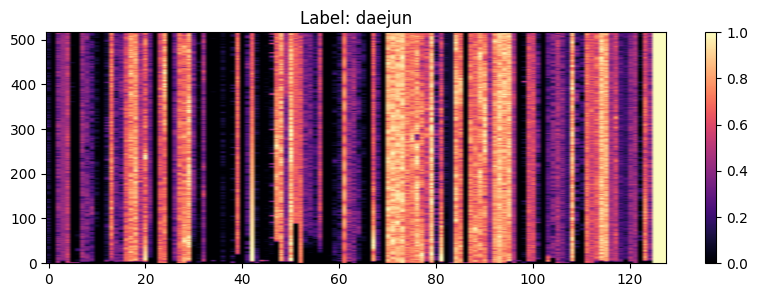

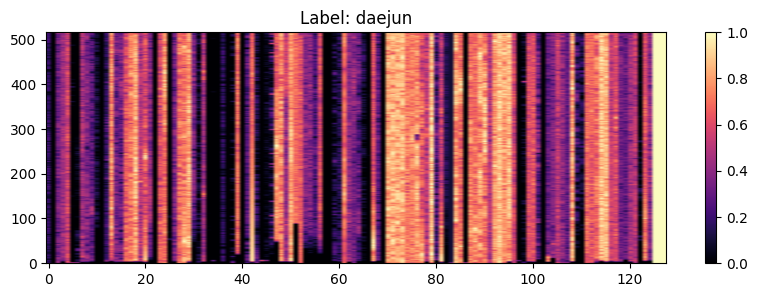

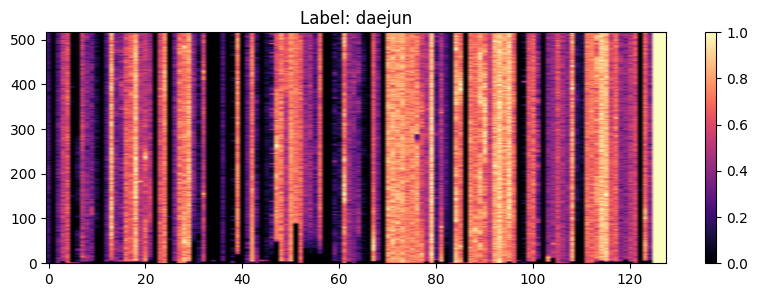

In [36]:
for i in range(3):
    plt.figure(figsize=(10, 3))
    plt.imshow(x_binary[i].squeeze(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Label: {y_binary[i]}")
    plt.colorbar()
    plt.show()

his one is much richer and clearer, which is a good sign

Now I will try training on model 3 that gave me the relatively best results

In [ ]:
history_bin3 = model3.fit(
    X_train_bin2, y_train_bin2,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_bin2, y_val_bin2),
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5462 - loss: 0.6943 - val_accuracy: 0.4902 - val_loss: 0.6928
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4403 - loss: 0.6959 - val_accuracy: 0.5098 - val_loss: 0.6885
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4698 - loss: 0.6894 - val_accuracy: 0.5098 - val_loss: 0.6819
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6007 - loss: 0.6812 - val_accuracy: 0.9608 - val_loss: 0.6704
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8718 - loss: 0.6659 - val_accuracy: 0.9020 - val_loss: 0.6501
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8540 - loss: 0.6501 - val_accuracy: 0.7843 - val_loss: 0.6213
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7502 - loss: 0.6196 - val_accuracy: 0.9216 - val_loss: 0.5766
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8626 - loss: 0.5803 - val_accuracy: 0.8235 - val_loss: 0.5329
Epoch 9/

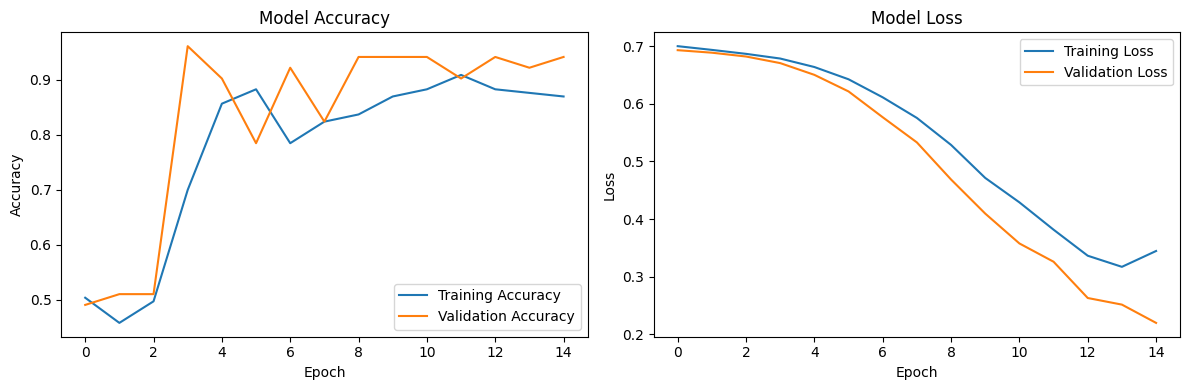

In [38]:
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_bin3.history['accuracy'], label='Training Accuracy')
plt.plot(history_bin3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_bin3.history['loss'], label='Training Loss')
plt.plot(history_bin3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

This time the model actually learned! At first, it was still a bit unstable — accuracy was bouncing around and loss wasn’t that low but around epoch 4, it took off. Training accuracy jumped past 85%.Validation accuracy even hit 96%, which means it was learning well. The loss kept dropping steadily, and by the end it was clearly locking onto meaningful patterns. So yeah, switching to the new normalized and padded data made a huge difference — even this simple model finally started performing well.

Now I can do final testing

# Final Testing and Evaluation
Now that the model is trained, let's evaluate it on the test set to see how it performs on unseen data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
Accuracy: 0.8653846153846154

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.88      0.85      0.86        26

    accuracy                           0.87        52
   macro avg       0.87      0.87      0.87        52
weighted avg       0.87      0.87      0.87        52



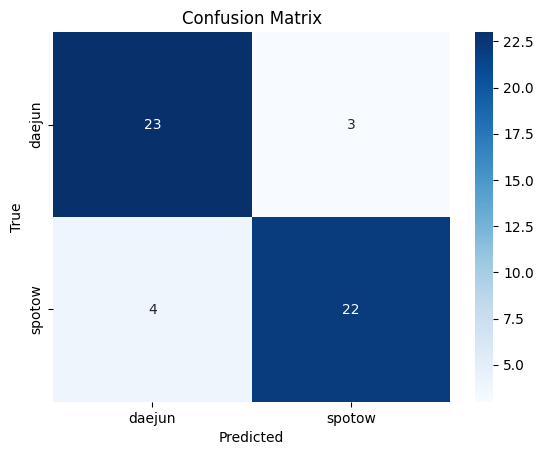

In [42]:
# Predict on test set
y_pred_bin = model3.predict(X_test_bin2)
y_pred_bin_labels = (y_pred_bin > 0.5).astype(int)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test_bin2, y_pred_bin_labels))
print("\nClassification Report:\n", classification_report(y_test_bin2, y_pred_bin_labels))

# Plot Confusion Matrix
cm = confusion_matrix(y_test_bin2, y_pred_bin_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=selected_species, yticklabels=selected_species)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

These results turned out really well. The model hit 86.5% accuracy on the test set, and it predicted both daejun and spotow pretty evenly. Precision and recall were close for both classes, and the f1-scores were around 0.86–0.87, so it’s clearly performing consistently. For such a simple model, I’m honestly impressed — the changes in preprocessing definitely paid off.
